In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports & Constant Paths

In [4]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from skimage import filters
from matplotlib import pyplot as plt
from sklearn import metrics as skmetrics
from scipy import interp
from itertools import cycle

import os
import collections
import json

In [5]:
TF_RECORDS_DB = "/content/drive/MyDrive/IE3_ML_Team/Data/TFRecords"
TRAIN = "TRAIN"
TEST = "TEST"
VAL = "VAL"

DB_MODELS = "/content/drive/MyDrive/IE3_ML_Team/Model"

In [7]:
LABELS = {'CN': 0, 'MCI': 1, 'AD': 2}
BINARY_LABELS = {'CN': 0, 'AD': 1}

ORIGINAL_IMG_SHAPE = (78, 110, 86)
IMG_2D_SHAPE = (ORIGINAL_IMG_SHAPE[1] * 4, 
                ORIGINAL_IMG_SHAPE[2] * 4, 
                1)
IMG_RGB_SHAPE = (ORIGINAL_IMG_SHAPE[1] * 4, 
                 ORIGINAL_IMG_SHAPE[2] * 4, 
                 3)

TEST_SPLIT = 0.15
VALIDATION_SPLIT = 0.15

### Checking TFRecords Data

In [16]:
#checking tfrecords data
training_tfrec = os.path.join(TF_RECORDS_DB, TRAIN)
testing_tfrec = os.path.join(TF_RECORDS_DB, TEST)
val_tfrec = os.path.join(TF_RECORDS_DB, VAL)

In [ ]:
def num_data_points(dataset,tfpath):
  num = 0
  for record in tf.data.TFRecordDataset(tfpath):
    num += 1
  print(f"Number of records for {dataset} = {num}")
  return num

In [ ]:
num_train = num_data_points("training",training_tfrec)
num_test = num_data_points("testing",testing_tfrec)
num_validation = num_data_points("validation",val_tfrec)
print(f"In total, there are {num_train + num_test + num_validation} records.")

Number of records for training = 1658
Number of records for testing = 343
Number of records for validation = 292
In total, there are 2293 records.


In [10]:
SHUFFLE_BUFFER = 100

In [8]:
# Code to import TFRecords
def decode(serialized_example):
  
  # decode examples stored in TFRecord
  feature = tf.io.parse_single_example(
      serialized_example,
      features = {
          'image': tf.io.FixedLenFeature(IMG_RGB_SHAPE, tf.float32),
          'label': tf.io.FixedLenFeature([], tf.int64)
      }
  )

  # encode the label
  label = tf.one_hot(feature['label'], 2)
  
  return feature['image'], label

In [9]:
def dataset_parser(filepath, batch_size, n_classes):
  ''' This method generates the dataset that is passed into the Keras model
      
      Parameters:
        filepath -- The complete path to the TFRecord file
        batch_size
        n_classes 
        
      Returns:
        dataset
  '''
  
  # create and configure the dataset
  dataset = tf.data.TFRecordDataset(filepath).map(decode)
  dataset = dataset.shuffle(SHUFFLE_BUFFER, seed=tf.random.set_seed(21))
  dataset = dataset.repeat()
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  
  return dataset

### Model Training

In [18]:
BATCH_SIZE = 16
  
STEPS_PER_EPOCH = num_train//BATCH_SIZE
VALIDATION_STEPS = num_validation//BATCH_SIZE

n_classes = len(BINARY_LABELS)


NameError: ignored

In [ ]:
train_dataset = dataset_parser(training_tfrec, 
                               BATCH_SIZE,
                               n_classes)

In [ ]:
# load validation data tensors
validation_dataset = dataset_parser(val_tfrec, 
                                    BATCH_SIZE, 
                                    n_classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_2D_SHAPE[0], IMG_2D_SHAPE[1], 3)))

# Add the max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add the max pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add the dense layer
model.add(Dense(64, activation='relu'))

# Add the output layer
model.add(Dense(2, activation='sigmoid'))

# Compile the model with the modified optimizer
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the data
model.fit(train_dataset, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH,validation_data=validation_dataset,validation_steps=VALIDATION_STEPS)

CHECK_POINT = "trained_cnn"
model_file = os.path.join(DB_MODELS, CHECK_POINT) + '.h5'
model.save(model_file) 

Epoch 1/20
103/103 [==============================] - 13s 100ms/step - loss: 2.6144 - accuracy: 0.4994 - val_loss: 0.6830 - val_accuracy: 0.4861
Epoch 2/20
103/103 [==============================] - 10s 102ms/step - loss: 0.6756 - accuracy: 0.4854 - val_loss: 0.6734 - val_accuracy: 0.4896
Epoch 3/20
103/103 [==============================] - 10s 99ms/step - loss: 0.6552 - accuracy: 0.4921 - val_loss: 0.6641 - val_accuracy: 0.5000
Epoch 4/20
103/103 [==============================] - 10s 96ms/step - loss: 0.5800 - accuracy: 0.6032 - val_loss: 0.7018 - val_accuracy: 0.5938
Epoch 5/20
103/103 [==============================] - 13s 126ms/step - loss: 0.3824 - accuracy: 0.7549 - val_loss: 0.6233 - val_accuracy: 0.6562
Epoch 6/20
103/103 [==============================] - 10s 93ms/step - loss: 0.1583 - accuracy: 0.8447 - val_loss: 0.6069 - val_accuracy: 0.7569
Epoch 7/20
103/103 [==============================] - 10s 98ms/step - loss: 0.0438 - accuracy: 0.8677 - val_loss: 0.6412 - val_accura

### Model Testing

In [12]:
model_file = os.path.join(DB_MODELS, "trained_cnn") + '.h5'
model = tf.keras.models.load_model(model_file)


In [13]:
def get_data_for_predict(tfrec_file, batch_size):
  ''' Read and return the data from a TFRecord file.
      
      Params:
        tfrec_file -- Absolute path to the .tfrecord
        
      
      Returns:
        dataset
  '''
  # create the iterator for the TFRecord
  dataset = tf.data.TFRecordDataset(tfrec_file).map(decode)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      
  return dataset

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def compute_auc(model,dataset, title):
  ''' Computes the ROC and AUC for a given model
      and a specific test set.
      
      Parameters:
        model -- The trained model
        dataset -- dataset
        title
  '''
  # Use the trained model to make predictions on the validation dataset
  y_pred = model.predict(dataset)

  # Calculate the true labels for the validation dataset
  y_true = np.concatenate([y for x, y in dataset], axis=0)

  fpr, tpr, thresholds = roc_curve(y_true[:, 1], y_pred[:, 1])
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

  plt.savefig(os.path.join(DB_MODELS, "roc_curve.png"))


  roc_auc = roc_auc_score(y_true, y_pred)
  print(roc_auc)
  

In [19]:
BATCH_SIZE = 16

training_dataset = get_data_for_predict(testing_tfrec, BATCH_SIZE)

22/22 [==============================] - 1s 58ms/step


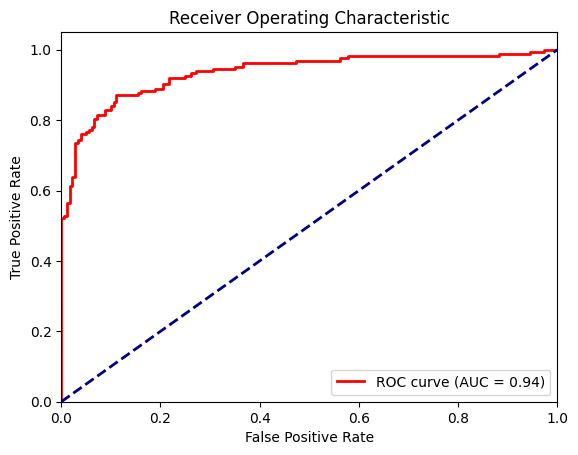

0.9443913756361639


<Figure size 640x480 with 0 Axes>

In [24]:
compute_auc(model, training_dataset, 'AUC for Sequential CNN')
